In [1]:
#Import the necessary libraries
import tensorflow.keras.backend as K 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Activation, Add,DepthwiseConv2D, BatchNormalization, Concatenate, Conv2D, Dense,Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Lambda,LeakyReLU, MaxPooling2D, Multiply, Permute, Reshape, UpSampling2D 
import collections
import tensorflow as tf
from tensorflow.keras import regularizers
from  tensorflow.keras.initializers import *
#from keras_flops import get_flops

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

In [3]:
#Model for classification
def res_block(x,f): 
    w,h,c = x.shape[1],x.shape[2],x.shape[3]
    x41 = AveragePooling2D(pool_size = (w,h))(x)
    x41 = Conv2D(f, (1, 1), activation='sigmoid', padding='same')(x41)
    x4 = Multiply()([x,x41])
    return x4
def conv_layer(x,f):
    conv1 = tf.keras.layers.Conv2D(f, kernel_size=(3, 3), padding='same')(x)
    norm1 = tf.keras.layers.BatchNormalization()(conv1)
    relu1 = tf.keras.layers.Activation('relu')(norm1)
    return relu1

def block(x,y):
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // 2
    x = Reshape([width, height, group_ch, 2])(x)
    x = Permute([1, 2, 4, 3])(x)
    x0 = x[:,:,:,0]
    x1 = x[:,:,:,1]
    
    _, width, height, channels = y.get_shape().as_list()
    group_ch = channels // 2
    y = Reshape([width, height, group_ch, 2])(y)
    y = Permute([1, 2, 4, 3])(y)
    y0 = y[:,:,:,0]
    y1 = y[:,:,:,1]
    
    xy0 = Concatenate()([x0,y1])
    xy1 = Concatenate()([y0,x1])
        
    xy2 = conv_layer(xy0, channels)
    xy3 = conv_layer(xy1, channels) 
    x_o = res_block(xy2, channels)
    y_o = res_block(xy3, channels)
    x_out = Add()([x_o,y_o]) 
    return x_out
def resnet_block(block_input, num_filters):
    conv1 = conv_layer(block_input,num_filters)
    conv2 = block(block_input,conv1)
    sum = Add()([conv2,block_input])
    relu2 = tf.keras.layers.Activation('relu')(sum)
    return relu2
############################################################################

#Classification model
def se_resnet14():
#Accepts the input image of size 256X256
  input = tf.keras.layers.Input(shape=(256, 256, 3))
  conv1 = conv_layer(input,16)

  block1 = resnet_block(conv1, 16)
  block2 = resnet_block(block1, 16)
  pool1 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block2)
  conv2 = conv_layer(pool1,32)
  block4 = resnet_block(conv2, 32)
  block5 = resnet_block(block4, 32)
  pool2 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block5)
  conv3 = conv_layer(pool2,64)
  block7 = resnet_block(conv3, 64)
  block8 = resnet_block(block7, 64)
  global_pool = tf.keras.layers.GlobalAveragePooling2D()(block8)
  x = Dense(128, activation='relu')(global_pool)
  x = Dense(64, activation='relu')(x)
    #Number of classes=2
  output = tf.keras.layers.Dense(2, activation='sigmoid')(x)
  model = tf.keras.models.Model(inputs=input, outputs=output)
  return model


In [4]:
def f1score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [5]:
image_shape=(512,512)
#Segmentation model
def unet(num_classes = 1, input_shape= (image_shape[0],image_shape[1], 3)):
  inp = Input(input_shape)
   # Block 0
  x = Conv2D(32, (3, 3), padding='same', name='block0_conv1')(inp)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3, 3), padding='same', name='block0_conv2')(x)
  x = BatchNormalization()(x)
  block_0_out = Activation('relu')(x)
  x = MaxPooling2D()(block_0_out)


  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)
  x = MaxPooling2D()(block_1_out)
  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)
  x = MaxPooling2D()(block_2_out)
  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)
  x = MaxPooling2D()(block_3_out)
  # Block 4
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
  x = BatchNormalization()(x)
  block_4_out = Activation('relu')(x)
  
 
  
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_3_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # UP 3
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_2_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # UP 4
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_1_out])
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

   # UP 5
  x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP5')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_0_out])
  x = Conv2D(32, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)




  x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)
 
  modelunet = Model(inputs=inp, outputs=x)

  
    
  return modelunet
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [6]:
#Classiifcation model trained with binary cross entropy
model_classfy = se_resnet14()
model_classfy.compile(optimizer = 'Adam' , loss = 'binary_crossentropy' , metrics = [f1score,"Accuracy","Recall","Precision"])
model_classfy.load_weights("/kaggle/input/classification-weights/WCE_Bleeding_classification (1).hdf5")

#Segmentaion model trained with dice_coef loss
model_segment = unet() 
adam = tf.keras.optimizers.Adam(lr=0.0001)
model_segment.compile(optimizer=adam,loss=dice_coef_loss,metrics=[tf.keras.metrics.MeanIoU(num_classes=2),"Precision"])#
model_segment.load_weights("/kaggle/input/segmentation-weights/WCE_Bleeding_segmentation (1).hdf5")

In [7]:
import os
import cv2
def drawtest(orig_im,recogn_im, out_im,cla):  
  plt.figure(figsize=(20,17))
  plt.subplot(1,3,1)
  plt.title(cla+" "+"frame")
  plt.imshow(cv2.cvtColor(orig_im, cv2.COLOR_BGR2RGB))
 # plt.imshow(orig_im,)cv2.cvtColor(orig_im, cv2.COLOR_BGR2RGB)  
  plt.subplot(1,3,2)
  plt.title('Bleeding region')
  plt.imshow(recogn_im)
  plt.subplot(1,3,3)
  plt.title('Out Unet')
  plt.imshow(out_im)
  plt.axis('off')
  plt.show()

def prepare_test_image(image):    
  x_batch = []   
  # img = cv2.imread(image_path)  
  input_shape=(256,256)
  img  = cv2.resize(image, input_shape, interpolation=cv2.INTER_AREA)
  x_batch+=[img]
  a=np.array(x_batch)/255.
  #print(a.shape)  
  return a




In [8]:
def prepare_test_image_segment(image):    
  x_batch = []  
  image_shape=(512,512)
  # img = cv2.imread(image_path)  
  img  = cv2.resize(image, image_shape, interpolation=cv2.INTER_AREA)
  x_batch += [img]           
  x_batch = np.array(x_batch) / 255.        

  return x_batch

def binaryImage(image):
  x = image.shape[1]
  y = image.shape[2]
  imgs = np.zeros((x,y,3))
  for k in range(x):
    for n in range(y):
      if image[0,k,n]>0.5:
        imgs[k,n,0]=255
        imgs[k,n,1]=255
        imgs[k,n,2]=255
        # print(imgs[k,n])
      # else:
      #   imgs[k,n]=0
  return imgs 




def recogn_testwce_image():
  #test_dir="/kaggle/input/wce-test-data/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2"
  #test_dir= Folder path consisting the images for prediction
  test_dir="/kaggle/input/wce-bleeding/WCEBleedGen/WCE_bleeding_detection/Val/Images"
  #test_masks = os.listdir(t_mask_dir)
  test_images = os.listdir(test_dir)
  ids_train_split = range(len(test_images))
  i=0
  for id in ids_train_split: 
    fname=test_dir+'/'+test_images[id]
    print(fname)
    im_test = cv2.imread(fname) 
    predictions = model_classfy.predict(prepare_test_image(im_test), verbose=0)  
    pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
    l=len(fname)
    #print(pred_labels)
    if(pred_labels==0):
        cla= "Bleeding"
    else:
        cla= "Non-Bleeding"
   
    out_test = model_segment.predict(prepare_test_image_segment(im_test), verbose=0)
    img_r = binaryImage(out_test)
    img_r=np.array(img_r, dtype="uint8")
    
    ret, thresh1 = cv2.threshold(img_r[:,:,0], 150, 255, cv2.THRESH_BINARY)
    contours, hierarchy= cv2.findContours(thresh1, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    sh=img_r.shape
    im_test  = cv2.resize(im_test, (sh[0],sh[1]), interpolation=cv2.INTER_AREA)
    cv2.drawContours(im_test, contours, -1, (0, 255, 0), 1, cv2.LINE_AA)
#     L=len(contours)    
#     for j in range(L-1,-1,-1):
#         cnt = contours[j]
#         # compute the bounding rectangle of the contour
#         x,y,w,h = cv2.boundingRect(cnt)
        
#         cv2.drawContours(im_test, contours, -1, (0, 255, 0), 1, cv2.LINE_AA)
# #         if(w>20 and h>20):
# #             cv2.rectangle(im_test,(x,y),(x+w,y+h),(0,255,0),1)
# #         if(j==L-3):
# #             break
        
    drawtest(im_test, img_r, out_test[0,:, :, 0]*255,cla) 
    i=i+1
    if(i==3):
        break
    





   

/kaggle/input/wce-bleeding/WCEBleedGen/WCE_bleeding_detection/Val/Images/img- (930).png


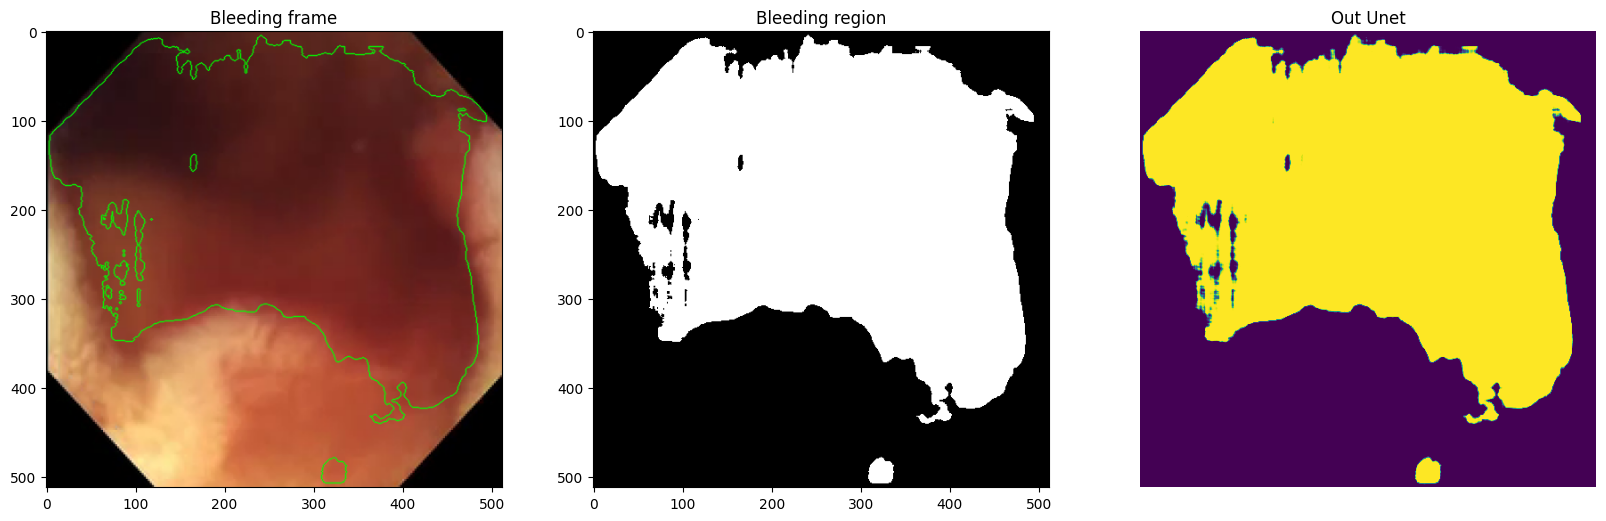

/kaggle/input/wce-bleeding/WCEBleedGen/WCE_bleeding_detection/Val/Images/img- (1097).png


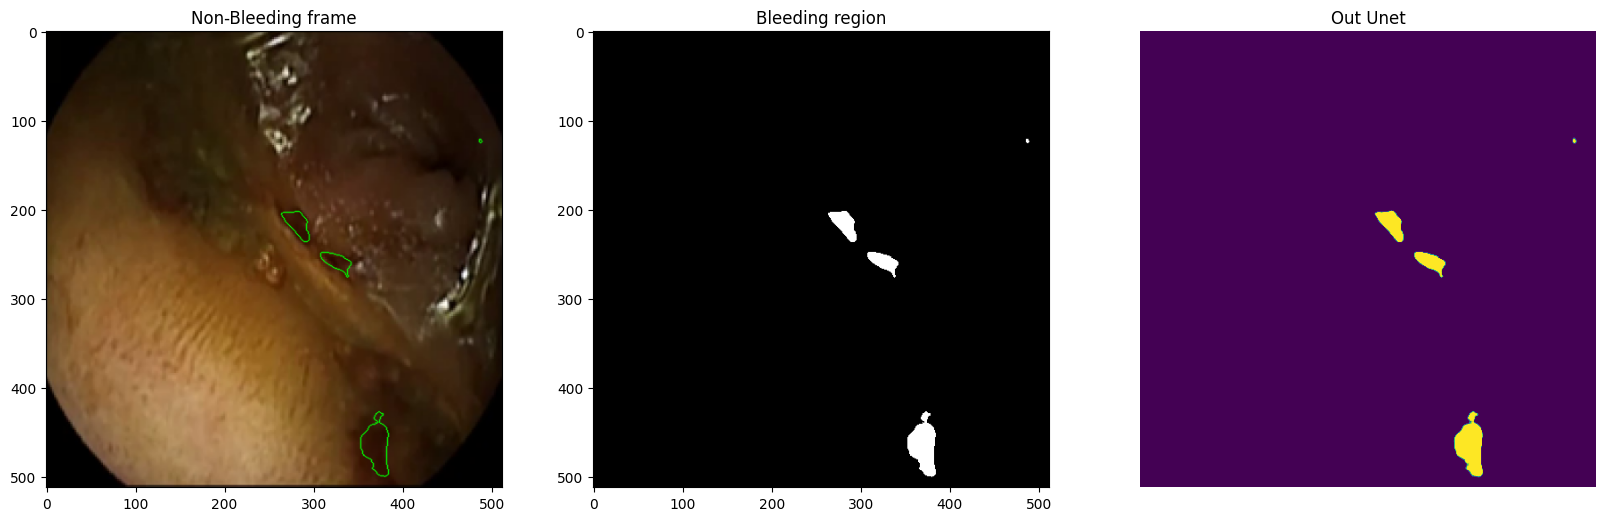

/kaggle/input/wce-bleeding/WCEBleedGen/WCE_bleeding_detection/Val/Images/img- (810).png


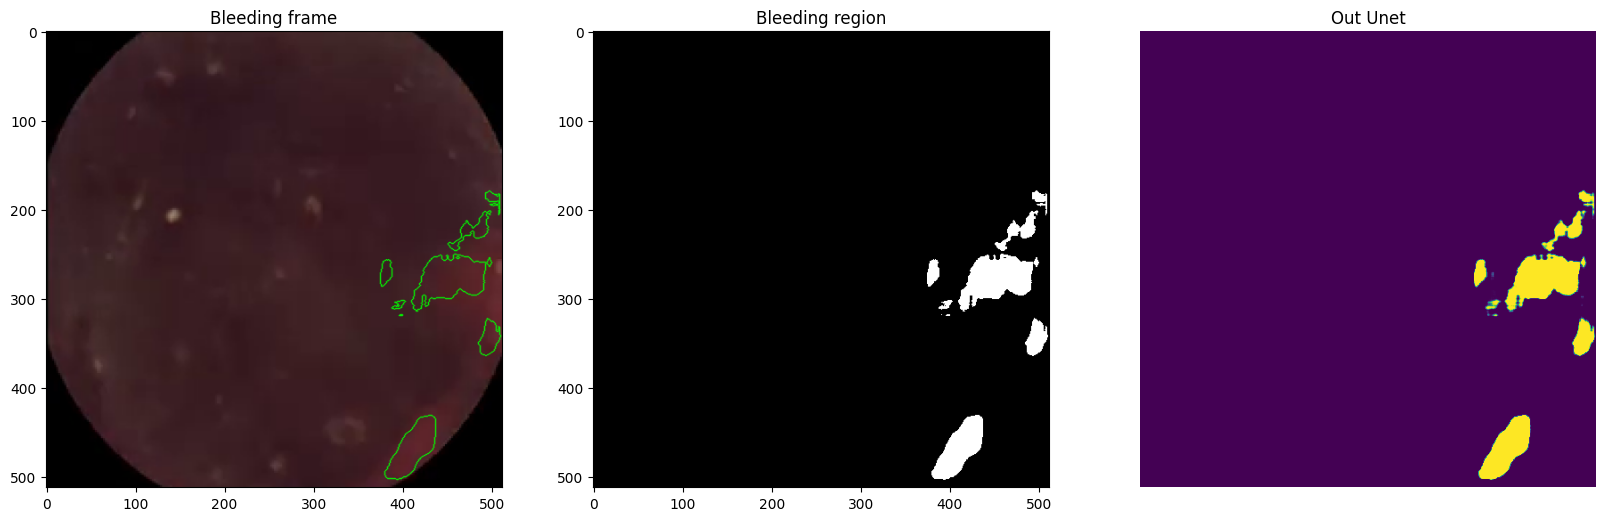

In [9]:
import numpy as np
import matplotlib.pyplot as plt
#Main function predicts the class of the image and detect the bleeding regions
recogn_testwce_image()

In [11]:
#Interpretability plots
!sed -i 's/from scipy.spatial import ConvexHull, QhullError/from scipy.spatial import ConvexHull/g' /opt/conda/lib/python3.10/site-packages/skimage/morphology/convex_hull.py
from lime import lime_image
explainer = lime_image.LimeImageExplainer(random_state=2021)
from skimage.segmentation import mark_boundaries

In [34]:
def explain_image_by_lime(image, label):
    explanation = explainer.explain_instance(image, model_classfy.predict, 
                                             top_labels=1, hide_color=0, num_samples=1)
    
    # show the top 3 superpixels that contribute to the class; do not show the rest of the image
    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=True, num_features=3, hide_rest=True)

    # show the top 3 positive or negative superpixels; make the entire image visible
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=False, num_features=3, hide_rest=False)
    
  

    fig = plt.figure(figsize=(16, 12), constrained_layout=True)    
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('original image', fontsize=14)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(temp_1, mask_1))
    plt.title('positive superpixels', fontsize=14)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(temp_2, mask_2), cmap='gray')
    plt.title('positive & negative superpixels', fontsize=14)
    plt.axis('off')
    plt.suptitle(label, y=0.8, fontsize=18)
    plt.show()